Visualize how well the class embeddings attend on words and
sentences. The expected result would be that the “married”
class embedding, for example, attends heavily on words and
sentences related to marriage like “married”, “husband”, “wife”, etc.

# Imports

In [48]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

from data.power.split.split_dir import SplitDir

from util import plot_tensor
from pathlib import Path
from random import shuffle
from typing import List, Tuple

import pandas as pd
from torch import tensor, Tensor
from torch.utils.data import DataLoader

from dao.ower.ower_dir import Sample
from data.power.samples.samples_dir import SamplesDir
from data.power.texter_pkl import TexterPkl

pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Args

In [31]:
texter_pkl_path = '../data/power/texter-v2/context_attend_cde-irt-5-marked.pkl'

# Input data
samples_dir_path = '../data/power/samples-v5/cde-irt-5-marked/'
class_count = 100
sent_count = 5

split_dir_path = '../data/power/split-v2/cde-0/'

# Pre-processing
sent_len = 64

# Testing
batch_size = 4

# Check data

In [32]:
#
# Check that (input) POWER Texter PKL exists
#

texter_pkl = TexterPkl(Path(texter_pkl_path))
texter_pkl.check()

#
# Check that (input) POWER Samples Directory exists
#

samples_dir = SamplesDir(Path(samples_dir_path))
samples_dir.check()

#
# Check that (input) Power Split Directory exists
#

split_dir = SplitDir(Path(split_dir_path))
split_dir.check()

# Load Texter

In [6]:
texter = texter_pkl.load().cpu()

# Load test data

In [43]:
test_set = samples_dir.test_samples_tsv.load(class_count, sent_count)

test_ent_to_sents = {sample.ent: sample.sents for sample in test_set}

def generate_batch(batch: List[Sample]) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    :param    batch:            [Sample(ent, ent_lbl, [class], [sent])]

    :return:  ent_batch:        IntTensor[batch_size],
              tok_lists_batch:  IntTensor[batch_size, sent_count, sent_len],
              masks_batch:      IntTensor[batch_size, sent_count, sent_len],
              classes_batch:    IntTensor[batch_size, class_count]
    """

    ent_batch, _, classes_batch, sents_batch = zip(*batch)

    for sents in sents_batch:
        shuffle(sents)

    flat_sents_batch = [sent for sents in sents_batch for sent in sents]

    encoded = texter.tokenizer(flat_sents_batch, padding=True, truncation=True, max_length=sent_len,
                               return_tensors='pt')

    b_size = len(ent_batch)  # usually b_size == batch_size, except for last batch in samples
    tok_lists_batch = encoded.input_ids.reshape(b_size, sent_count, -1)
    masks_batch = encoded.attention_mask.reshape(b_size, sent_count, -1)

    return tensor(ent_batch), tok_lists_batch, masks_batch, tensor(classes_batch)


test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=generate_batch)

# Load Debug Info

In [33]:
# Load class info
rel_tail_freq_lbl_list = samples_dir.classes_tsv.load()

# load test ent labels
test_ent_to_lbl = split_dir.test_entities_tsv.load()

# Predict test entities

Q39792:Jack Nicholson
sents
['Too Soon to Love, also known as High School Honeymoon and Teenage Lovers, is '
 'a 1960 American exploitation film directed by Richard Rush and starring '
 'Richard Evans, Jennifer West and [MENTION_START] Jack Nicholson '
 '[MENTION_END].',
 'Roger Ebert added it to his "Great Movies" list, saying that Nicholson\'s '
 'performance was "key in keeping Chinatown from becoming just a genre crime '
 'picture", along with Towne\'s screenplay, concluding that the film "seems to '
 'settle easily beside the original noirs".',
 'Among his clients in Spain: actors Antonio Banderas and his wife, Melanie '
 'Griffith, soccer star David Beckham, Spanish actresses Ana Obregón and '
 'Esther Cañadas, former Spice Girl Emma Bunton, bullfighter Francisco Rivera '
 'Ordóñez and several high-profile businessmen Before his defection, Fernández '
 'claims that one of his key tasks was to spy on wealthy visitors to the '
 'island, including film stars Leonardo DiCaprio and [M

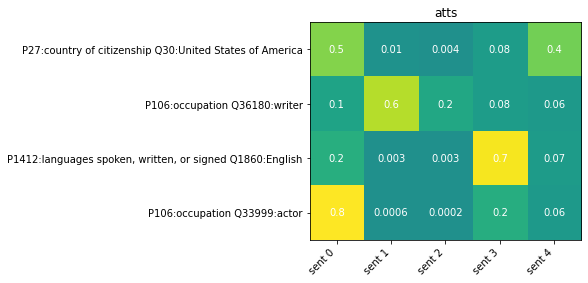

no_att_logits
tensor([[ 2.6217, -1.9006,  1.7273,  6.3161],
        [ 1.6443,  3.0619,  1.8650, -0.2484],
        [ 1.4563, -0.7367,  1.6972,  5.8129],
        [ 1.2563, -4.1804,  3.4853,  5.7156],
        [ 4.8115, -0.0811,  2.3053,  5.7552]], grad_fn=<SliceBackward>)
Q57382:Christa Wolf
sents
["For VAN, Giovetti has also covered her father's suicide via Richard Wagner's "
 "The Flying Dutchman, Schubert's Winterreise in the context of East German "
 'author [MENTION_START] Christa Wolf [MENTION_END] and the 2017 Unite the '
 'Right rally, and her relationship with Dmitri Hvorostovsky.',
 'His study of [MENTION_START] Christa Wolf [MENTION_END]’s earlier novels '
 '(Existenz und Heldentum bei [MENTION_START] Christa Wolf [MENTION_END].',
 'In collaboration with the German expatriate Hedwig Rappolt she translated '
 "[MENTION_START] Christa Wolf [MENTION_END]'s novel Kindheitsmuster (Patterns "
 'of Childhood).Discussed in: Graeme Dunphy, "Tracking [MENTION_START] Christa '
 'Wolf [MEN

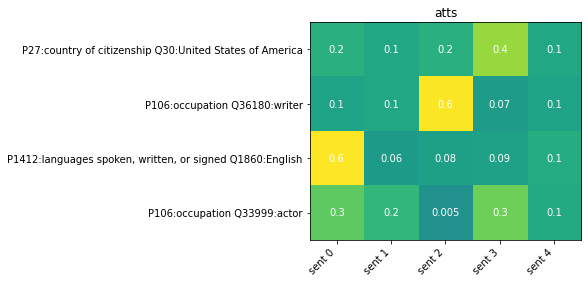

no_att_logits
tensor([[-3.4554,  3.4456, -0.9253, -1.2924],
        [-1.4879,  2.4044, -3.5600, -4.4200],
        [ 0.7311,  7.9516,  0.0964, -2.5244],
        [-1.5658,  5.2484, -1.8503, -1.4401],
        [-1.3676,  7.0373, -3.4468, -1.6276]], grad_fn=<SliceBackward>)
Q255725:Maria Tănase
sents
['On the [MENTION_START] Maria Tănase [MENTION_END] compilation Magic Bird - '
 'The Early Years, there are two.',
 'Some of the most important singers of popular music from this period are '
 '[MENTION_START] Maria Tănase [MENTION_END] and Maria Lătăreţu.',
 '[MENTION_START] Maria Tănase [MENTION_END], Maria Lătăreţu, Maria Ciobanu '
 'and Ileana Sararoiu are considered to be some of the greatest Romanian folk '
 'singers and The dances are lively and are practiced throughout Romania by a '
 'large number of professional and amateur groups, thus keeping the tradition '
 "alive; Hora is one of the most famous group dances but men's folk dances "
 'such as căluşari are extremely complex and have

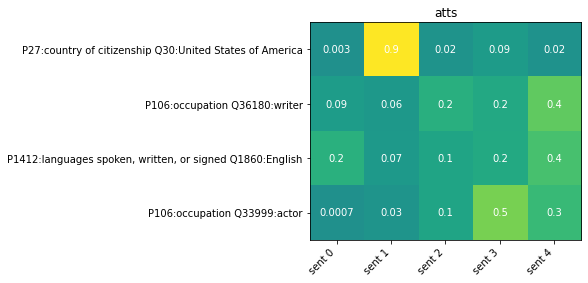

no_att_logits
tensor([[-0.7744,  3.3217, -0.4449,  1.1393],
        [-6.7190, -0.3804, -3.1275,  0.8417],
        [-5.7201,  0.9420, -1.6663,  0.3209],
        [-6.4194, -1.9302, -0.7342,  1.1114],
        [-5.4386,  1.7695, -2.3674, -0.5956]], grad_fn=<SliceBackward>)
Q75793:Alfred Hoche
sents
['The T4 program was influenced by a popular book, Allowing the destruction of '
 'life unworthy of living, written in 1920 by [MENTION_START] Alfred Hoche '
 '[MENTION_END] and Karl Binding.',
 'On 1 August 1901 he became an assistant physician at the psychiatric clinic '
 'and mental hospital in Freiburg, working under the noted psychiatrist '
 '[MENTION_START] Alfred Hoche [MENTION_END], one of the most vocal critics of '
 'the "natural disease entities" classification of Emil Kraepelin.',
 'A special euthanasia program, called Aktion T4 began in 1939, related '
 'propaganda arguments were based on the books, Die Freigabe der Vernichtung '
 'lebensunwerten Lebens (" Allowing the Destruction o

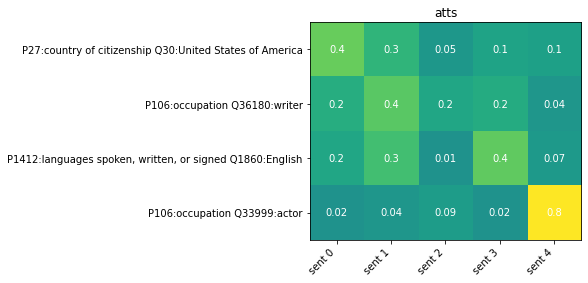

no_att_logits
tensor([[ 0.1622,  3.6421, -0.7607, -4.4632],
        [-2.3308, -0.1047, -3.9515, -6.2296],
        [-4.3113,  2.8037, -4.4586, -5.8618],
        [ 1.6671,  3.9868, -1.4829, -4.8682],
        [-3.6552,  0.5176, -4.5201, -7.5180]], grad_fn=<SliceBackward>)


In [50]:
limit_classes = 4

texter.eval()

for i, (ent_batch, sents_batch, masks_batch, gt_batch) in enumerate(test_loader):
    if i == 1:
        break

    # print('ent_batch', ent_batch)
    # print('sent_batch', sents_batch)
    # print('masks_batch', masks_batch)
    # print('gt_batch', gt_batch)

    logits_batch, atts_batch, = texter(sents_batch, masks_batch)
    no_att_logits_batch = texter.forward_without_attention(sents_batch, masks_batch)

    # print('logits_batch', logits_batch)
    # print('atts_batch', atts_batch)

    for ent, sents, masks, gt, logits, atts, no_att_logits in \
            zip(ent_batch, sents_batch, masks_batch, gt_batch, logits_batch, atts_batch, no_att_logits_batch):
        print(test_ent_to_lbl[ent.item()])

        print('sents')
        pprint(test_ent_to_sents[ent.item()])

        # print('masks')
        # pprint(masks)

        print('gt')
        pprint(gt[:limit_classes])

        print('logits')
        pprint(logits[:limit_classes])

        print('atts')
        pprint(atts[:limit_classes])

        class_labels = [rel_tail_freq_lbl_list[c][3] for c in range(class_count)][:4]
        sent_labels = [f'sent {s}' for s in range(sent_count)]
        plot_tensor(atts[:limit_classes], 'atts', [class_labels, sent_labels])

        print('no_att_logits')
        pprint(no_att_logits[:,:limit_classes])